#CartPole-v0

Code from https://jonghyunho.github.io/reinforcement/learning/cartpole-reinforcement-learning.html

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


episode:   0 | score avg 37.00 | memory length:   37 | epsilon: 1.0000 | loss: 0.00
episode:   1 | score avg 35.70 | memory length:   61 | epsilon: 1.0000 | loss: 0.00
episode:   2 | score avg 33.33 | memory length:   73 | epsilon: 1.0000 | loss: 0.00
episode:   3 | score avg 31.10 | memory length:   84 | epsilon: 1.0000 | loss: 0.00
episode:   4 | score avg 29.99 | memory length:  104 | epsilon: 1.0000 | loss: 0.00
episode:   5 | score avg 28.79 | memory length:  122 | epsilon: 1.0000 | loss: 0.00
episode:   6 | score avg 27.41 | memory length:  137 | epsilon: 1.0000 | loss: 0.00
episode:   7 | score avg 26.37 | memory length:  154 | epsilon: 1.0000 | loss: 0.00
episode:   8 | score avg 25.93 | memory length:  176 | epsilon: 1.0000 | loss: 0.00
episode:   9 | score avg 26.84 | memory length:  211 | epsilon: 1.0000 | loss: 0.00
episode:  10 | score avg 25.45 | memory length:  224 | epsilon: 1.0000 | loss: 0.00
episode:  11 | score avg 24.41 | memory length:  239 | epsilon: 1.0000 | los

SystemError: ignored

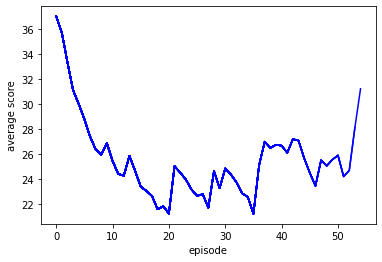

In [ ]:
import gym
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import Adam
class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size, kernel_initializer=RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        self.memory = deque(maxlen=2000)
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.optimizer = Adam(lr=self.learning_rate)
		
        self.update_target_model()
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def choose_action(self, state):
        return random.randrange(self.action_size) if (np.random.rand() <= self.epsilon) else np.argmax(self.model.predict(state))
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        model_params = self.model.trainable_variables
        loss = 0 ####
        with tf.GradientTape() as tape:
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)
            # 궁금증: reduce_sum을 하게 되면 특정 action에 대한 predict값을 얻긴 하겠지만 어떤 action으로 해당 predict값이 나왔는지는 무시될텐데 이걸 살리는게 맞지 않나?
            # ㄴ 결국 GradientTape에 기록되는 거니까 이 reduce_sum 또한 gradient에 계산되어 Stochastic Gradient Descent의 스텝에 반영돼서 apply gradient 되는 것인가
            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)

            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))

        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))
        return loss.numpy()######
if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    loss = [] ###########
    scores, episodes = [], []
    score_avg = 0
    num_episode = 300
    for e in range(num_episode):
        done = False
        score = 0

        state = env.reset()
        state = state.reshape(1, -1)
        while not done:
            action = agent.choose_action(state)

            next_state, reward, done, info = env.step(action)
            next_state = next_state.reshape(1, -1)

            score += reward
            reward = 0.1 if not done or score == 500 else -1

            agent.remember(state, action, reward, next_state, done)

            if len(agent.memory) >= agent.train_start:
                loss.append(agent.train_model()) #################

            state = next_state
            if done:
                agent.update_target_model()

                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print('episode: {:3d} | score avg {:3.2f} | memory length: {:4d} | epsilon: {:.4f} | loss: {:4.2f}'.format(e, score_avg, len(agent.memory), agent.epsilon, sum(loss) / (len(loss) + 1)))

                scores.append(score_avg)
                episodes.append(e)
                plt.plot(episodes, scores, 'b')
                plt.xlabel('episode')
                plt.ylabel('average score')
                plt.savefig('cartpole_graph.png')

                if score_avg  > 300:
                    agent.model.save_weights('./save_model/model', save_format='tf')
                    sys.exit()

###Try1

In [ ]:
# Setting
import gym
env = gym.make("CartPole-v0")

In [ ]:
# with no batch
import tensorflow as tf
import numpy as np

class Func():
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    def relu(z):
        return np.maximum(z, 0)
    def softmax(z):
        return np.exp(z) / np.exp(z).sum(axis=0)

class Layer():
    def __init__(self, input_unit, output_unit, act_func):
        self.weight = tf.Variable(tf.random.normal([output_unit, input_unit]) * 0.1)
        self.bias = tf.Variable(tf.random.normal([output_unit, 1]) * 0.1)
        self.Variables = [self.weight, self.bias]
        self.act_func = act_func
        self.result = None
    def linear_func(self, input):
        return tf.matmul(self.weight, input) + self.bias
    def forward(self, input):
        linear = self.linear_func(input)
        if self.act_func == 'softmax':
            return tf.nn.softmax(linear)
        elif self.act_func == 'relu':
            return tf.nn.relu(linear)
        elif self.act_func == 'sigmoid':
            return tf.sigmoid(linear)
        elif self.act_func == 'linear':
            return linear
        else:
            raise ValueError("Activation Function Name Error")
    def predict(self, input):
        linear = np.matmul(self.weight.numpy(), input) + self.bias.numpy()
        if self.act_func == 'softmax':
            return Func.softmax(linear)
        elif self.act_func == 'relu':
            return Func.relu(linear)
        elif self.act_func == 'sigmoid':
            return Func.relu(linear)
        elif self.act_func == 'linear':
            return linear
        else:
            raise ValueError("Activation Function Name Error")

class DQN():
    def __init__(self, state_size, action_size):
        self.Layers = []
        self.Layers.append(Layer(state_size, 24, 'relu'))
        self.Layers.append(Layer(24, 24, 'relu'))
        self.Layers.append(Layer(24, action_size, 'softmax'))
        self.Variables = []
        for layer in self.Layers:
            self.Variables.extend(layer.Variables)
    def forward(self, input):
        result = [self.Layers[0].forward(input)]
        for layer in self.Layers[1:]:
            result.append(layer.forward(result[-1]))
        return result[-1]
    def predict(self, input):
        return self.forward(input).numpy()
    def addLayer(self, input_unit, output_unit, act_func):
        self.Layers.append(Layer(input_unit, output_unit, act_func))
        self.Variables.extend(self.Layers[-1].Variables)
    def loss_fn(self, input, output):
        cost = tf.reduce_sum(tf.square(output - self.forward(input)), axis=0)
        return tf.reduce_mean(cost)
    def cross_entropy(self, input, output):
        cost = tf.reduce_sum(tf.multiply(output, tf.math.log(self.forward(input))), axis=0)
        return -tf.reduce_mean(cost)
    def grad(self, input, output):
        with tf.GradientTape() as tape:
            cost = self.cross_entropy(input, output)
            return tape.gradient(cost, self.Variables)
    def train(self, input, output, learning_rate, EPOCHS):
        optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
        for iter in range(EPOCHS + 1):
            grads = self.grad(input, output)
            optimizer.apply_gradients(grads_and_vars=zip(grads, self.Variables))
            error = self.cross_entropy(input, output)
            #if iter % (EPOCHS / 10) == 0:
                #print("iter:", iter, "error:", error.numpy())
        return error
    def test_accuracy(self, input, output):
        prob = np.average((np.argmax(self.forward(input), axis=0) == np.argmax(output, axis=0))) * 100
        print("Test Accuracy: {:10.4f}".format(prob))
        return prob

In [ ]:
episodes = 200
score_sum = 0
discount = 0.9
model = DQN(env.observation_space.shape[0], env.action_space.n)

for i in range(episodes):
    state = reshape_state(env.reset())
    done = False
    score = 0

    features = state
    labels = model.predict(state)

    while not done:
        action = np.argmax(model.predict(state) + np.random.randn(env.action_space.n, 1) / (i + 1))
        new_state, reward, done, info = env.step(action)
        new_state = reshape_state(new_state)
        label = model.predict(state)
        if done:
            label[action] = reward - 10
        else:
            label[action] = reward + discount * model.predict(new_state).max()
        
        features = np.append(features, state, axis=1)
        labels = np.append(labels, label, axis=1) 

        state = new_state
        score += reward
    score_sum += score
    error = model.train(features[:,1:], labels[:,1:], 0.001, EPOCHS=100)
    
    if i % (episodes / 10) == 0:
        print("episode: {:4} cost: {:10.4f} score_avg: {:10.4f}".format(i, error, score_sum / (i + 1)))

episode:    0 cost:     6.1543 score_avg:    16.0000
episode:   20 cost:     4.9384 score_avg:    22.9048
episode:   40 cost:     7.9114 score_avg:    22.5854
episode:   60 cost:     8.3567 score_avg:    23.1639
episode:   80 cost:     8.7145 score_avg:    23.0123
episode:  100 cost:     7.8572 score_avg:    22.5545
episode:  120 cost:     6.0789 score_avg:    22.0579
episode:  140 cost:     7.9610 score_avg:    22.2837
episode:  160 cost:     5.0077 score_avg:    22.1366
episode:  180 cost:     5.2031 score_avg:    22.1050


###Try4

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


episode:   0 | score avg  12.00 | memory length:   12 | epsilon: 1.0000 | loss: 0.00
episode:   1 | score avg  11.80 | memory length:   22 | epsilon: 1.0000 | loss: 0.00
episode:   2 | score avg  12.52 | memory length:   41 | epsilon: 1.0000 | loss: 0.00
episode:   3 | score avg  12.37 | memory length:   52 | epsilon: 1.0000 | loss: 0.00
episode:   4 | score avg  14.73 | memory length:   88 | epsilon: 1.0000 | loss: 0.00
episode:   5 | score avg  15.46 | memory length:  110 | epsilon: 1.0000 | loss: 0.00
episode:   6 | score avg  15.51 | memory length:  126 | epsilon: 1.0000 | loss: 0.00
episode:   7 | score avg  15.96 | memory length:  146 | epsilon: 1.0000 | loss: 0.00
episode:   8 | score avg  15.86 | memory length:  161 | epsilon: 1.0000 | loss: 0.00
episode:   9 | score avg  16.58 | memory length:  184 | epsilon: 1.0000 | loss: 0.00
episode:  10 | score avg  16.02 | memory length:  195 | epsilon: 1.0000 | loss: 0.00
episode:  11 | score avg  18.12 | memory length:  232 | epsilon: 

AttributeError: ignored

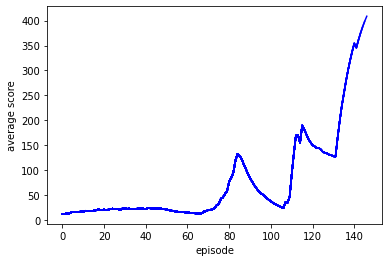

In [ ]:
import gym
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import Adam
class Layer():
    def __init__(self, input_unit, output_unit, act_func):
        self.weight = tf.Variable(tf.random.normal([input_unit, output_unit]) * 0.01) # shape: (n0, n1)
        self.bias = tf.Variable(tf.random.normal([1, output_unit]) * 0.01) # shape: (1, n1)
        self.act_func = act_func
    def forward(self, input): # input shape: (m, n0)
        linear = tf.matmul(input, self.weight) + self.bias
        if self.act_func == 'relu':
            return tf.nn.relu(linear)
        elif self.act_func == 'softmax':
            return tf.nn.softmax(linear)
        elif self.act_func == 'linear':
            return linear
        elif self.act_func == 'sigmoid':
            return tf.sigmoid(lienar)
        else:
            raise ValueError("Activation function name Error")

class DQN():
    def __init__(self, state_size, action_size):
        self.Layers = []
        self.Layers.append(Layer(state_size, 24, 'relu'))
        self.Layers.append(Layer(24, 24, 'relu'))
        self.Layers.append(Layer(24, 24, 'relu'))
        self.Layers.append(Layer(24, action_size, 'linear'))
        self.Variables = []
        for layer in self.Layers:
            self.Variables.append(layer.weight)
            self.Variables.append(layer.bias)
    def forward(self, state):
        for layer in self.Layers:
            result = layer.forward(state)
            state = result
        return result
    def predict(self, state):
        return self.forward(state).numpy()
    def get_variables(self):
        return self.Variables
    def set_variables(self, vars):
        self.Variables = vars
        for idx in range(len(self.Layers)):
            self.Layers[idx].weight = vars[idx * 2]
            self.Layers[idx].bias = vars[idx * 2 + 1]
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.001
        self.batch_size = 64
        self.train_start = 1000
        self.memory = deque(maxlen=2000)
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = Adam(lr=self.learning_rate)
		
        self.update_target_model()
    def update_target_model(self):
        self.target_model.set_variables(self.model.get_variables())
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def choose_action(self, state):
        return random.randrange(self.action_size) if (np.random.rand() <= self.epsilon) else np.argmax(self.model.predict(state))
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in mini_batch], dtype=np.float32)
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch], dtype=np.float32)
        dones = np.array([sample[4] for sample in mini_batch])

        model_params = self.model.Variables
        with tf.GradientTape() as tape:
            predicts = self.model.forward(states)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            target_predicts = self.target_model.forward(next_states)
            target_predicts = tf.stop_gradient(target_predicts)

            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))

        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))
        return loss
if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []
    score_avg = 0
    losses = []
    num_episode = 300
    for e in range(num_episode):
        done = False
        score = 0

        state = env.reset()
        state = state.reshape(1, -1).astype(np.float32)
        while not done:
            action = agent.choose_action(state)

            next_state, reward, done, info = env.step(action)
            next_state = next_state.reshape(1, -1).astype(np.float32)

            score += reward
            reward = 0.1 if not done or score == 500 else -1

            agent.remember(state, action, reward, next_state, done)

            if len(agent.memory) >= agent.train_start:
                losses.append(agent.train_model())

            state = next_state
            if done:
                agent.update_target_model()

                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print('episode: {:3d} | score avg {:6.2f} | memory length: {:4d} | epsilon: {:.4f} | loss: {:4.2f}'.format(e, score_avg, len(agent.memory), agent.epsilon, sum(losses) / (len(losses) + 1)))

                scores.append(score_avg)
                episodes.append(e)
                plt.plot(episodes, scores, 'b')
                plt.xlabel('episode')
                plt.ylabel('average score')
                plt.savefig('cartpole_graph.png')

                if score_avg  > 400:
                    agent.model.save_weights('./save_model/model', save_format='tf')
                    sys.exit()

#FrozenLake-v0

In [3]:
import numpy as np
import gym
import tensorflow as tf
import random
from collections import deque
import sys

class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.layer1 = tf.keras.layers.Dense(32, activation='relu')
        self.layer2 = tf.keras.layers.Dense(32, activation='relu')
        self.layer3 = tf.keras.layers.Dense(32, activation='relu')
        self.layer4 = tf.keras.layers.Dense(32, activation='relu')
        self.layer_out = tf.keras.layers.Dense(action_size, kernel_initializer=tf.keras.initializers.RandomUniform(-1e-2, 1e-2), activation='softmax')
    
    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        q = self.layer_out(x)
        return q

class DQNAgent():
    def __init__(self, state_size, action_size):
        self.learning_rate = 0.01
        self.epsilon = 1.
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.discount = 0.9
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.action_size = action_size
        self.state_size = state_size
        self.batch_size = 100
        self.train_start = 1000
        self.memory = deque(maxlen=10000)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        self.update_target_model()
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def train(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in batch], dtype=np.float32) # shape(m, state_size)
        actions = tf.one_hot(np.array([sample[1] for sample in batch], dtype=np.float32), self.action_size) # shape(m, action_size)
        rewards = np.array([sample[2] for sample in batch], dtype=np.float32)
        next_states = np.array([sample[3][0] for sample in batch], dtype=np.float32)
        dones = np.array([sample[4] for sample in batch], dtype=np.float32)

        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            predicts = self.model(states) # shape(m, action_size)
            predicts = tf.multiply(predicts, actions) # predict val of selected action: same, predict val of not selected: 0

            target_predicts = self.target_model(next_states)
            max_q = np.amax(target_predicts, axis=1) # np.amax: return maximum value // max_q: maximum q-vals(predicted) for every examples and so shape is (m, )
            targets = rewards + self.discount * tf.multiply(1 - dones, max_q) # (1 - dones) * max_q : if done, result is 0, if not, result stays
            targets = np.expand_dims(targets, axis=1) # shape(m, 1) // should add dim to multiply with shape(m, action_size) we cannot multiply shape(m, ) with shape(m, action_size)
            targets = tf.multiply(actions, targets)
            targets = tf.stop_gradient(targets)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(targets, predicts))
            #loss = tf.reduce_mean(tf.reduce_sum((targets - predicts) ** 2, axis=1))
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))
        return loss.numpy()

def reshape_state(state, state_size):
    return np.identity(state_size)[state:(state + 1), :]

if __name__ == '__main__':
    env = gym.make('FrozenLake-v0')
    episodes = 1000
    state_size = env.observation_space.n
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    scores, losses = [], [0.]
    for episode in range(episodes):
        done = False
        score = 0

        state = env.reset()
        state = reshape_state(state, state_size)
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = reshape_state(next_state, state_size)

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if len(agent.memory) > agent.train_start:
                losses.append(agent.train())
            
        scores.append(score)
        print("episode: {:4d} | score: {:3.0f} | epsilon: {:.3f} | memory len: {:4} | loss: {:4.2f}".format(episode, sum(scores), agent.epsilon, len(agent.memory), losses[-1]))
        agent.update_target_model()

episode:    0 | score:   0 | epsilon: 1.000 | memory len:   10 | loss: 0.00
episode:    1 | score:   0 | epsilon: 1.000 | memory len:   16 | loss: 0.00
episode:    2 | score:   0 | epsilon: 1.000 | memory len:   19 | loss: 0.00
episode:    3 | score:   0 | epsilon: 1.000 | memory len:   23 | loss: 0.00
episode:    4 | score:   0 | epsilon: 1.000 | memory len:   31 | loss: 0.00
episode:    5 | score:   0 | epsilon: 1.000 | memory len:   44 | loss: 0.00
episode:    6 | score:   0 | epsilon: 1.000 | memory len:   46 | loss: 0.00
episode:    7 | score:   0 | epsilon: 1.000 | memory len:   54 | loss: 0.00
episode:    8 | score:   0 | epsilon: 1.000 | memory len:   60 | loss: 0.00
episode:    9 | score:   0 | epsilon: 1.000 | memory len:   67 | loss: 0.00
episode:   10 | score:   0 | epsilon: 1.000 | memory len:   75 | loss: 0.00
episode:   11 | score:   0 | epsilon: 1.000 | memory len:   77 | loss: 0.00
episode:   12 | score:   0 | epsilon: 1.000 | memory len:   81 | loss: 0.00
episode:   1

0.085


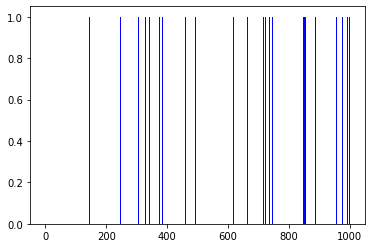

In [4]:
print(np.average(scores))
import matplotlib.pyplot as plt
plt.bar(range(len(scores)), scores, color='blue')
plt.show()

In [12]:
import numpy as np
import gym
import tensorflow as tf
import random
from collections import deque
import sys

class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.layer1 = tf.keras.layers.Dense(64, activation='relu')
        self.layer2 = tf.keras.layers.Dense(64, activation='relu')
        self.layer3 = tf.keras.layers.Dense(64, activation='relu')
        self.layer4 = tf.keras.layers.Dense(64, activation='relu')
        self.layer_out = tf.keras.layers.Dense(action_size, kernel_initializer=tf.keras.initializers.RandomUniform(-1e-2, 1e-2), activation='linear')
    
    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        q = self.layer_out(x)
        return q

class DQNAgent():
    def __init__(self, state_size, action_size):
        self.learning_rate = 0.001
        self.epsilon = 1.
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.discount = 0.9
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.action_size = action_size
        self.state_size = state_size
        self.batch_size = 100
        self.train_start = 1000
        self.memory = deque(maxlen=10000)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        self.update_target_model()
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def train(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in batch], dtype=np.float32) # shape(m, state_size)
        actions = np.array([sample[1] for sample in batch], dtype=np.float32)
        rewards = np.array([sample[2] for sample in batch], dtype=np.float32)
        next_states = np.array([sample[3][0] for sample in batch], dtype=np.float32)
        dones = np.array([sample[4] for sample in batch], dtype=np.float32)

        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            predicts = self.model(states) # shape(m, action_size)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            target_predicts = self.target_model(next_states)
            max_q = np.amax(target_predicts, axis=1) # np.amax: return maximum value // max_q: maximum q-vals(predicted) for every examples and so shape is (m, )
            targets = rewards + self.discount * tf.multiply(1 - dones, max_q) # (1 - dones) * max_q : if done, result is 0, if not, result stays
            targets = tf.stop_gradient(targets)
            #loss = tf.nn.softmax_cross_entropy_with_logits(targets, predicts)
            loss = tf.reduce_mean(tf.square(targets - predicts))
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))
        return loss.numpy()

def reshape_state(state, state_size):
    return np.identity(state_size)[state:(state + 1), :]

if __name__ == '__main__':
    env = gym.make('FrozenLake-v0')
    episodes = 1000
    state_size = env.observation_space.n
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    scores, losses = [], [0.]
    for episode in range(episodes):
        done = False
        score = 0

        state = env.reset()
        state = reshape_state(state, state_size)
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = reshape_state(next_state, state_size)

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if len(agent.memory) > agent.train_start:
                losses.append(agent.train())
            
        scores.append(score)
        print("episode: {:4d} | score: {:3.0f} | epsilon: {:.3f} | memory len: {:4} | loss: {:4.2f}".format(episode, sum(scores), agent.epsilon, len(agent.memory), losses[-1]))
        agent.update_target_model()

episode:    0 | score:   0 | epsilon: 1.000 | memory len:   10 | loss: 0.00
episode:    1 | score:   0 | epsilon: 1.000 | memory len:   16 | loss: 0.00
episode:    2 | score:   0 | epsilon: 1.000 | memory len:   25 | loss: 0.00
episode:    3 | score:   0 | epsilon: 1.000 | memory len:   30 | loss: 0.00
episode:    4 | score:   0 | epsilon: 1.000 | memory len:   32 | loss: 0.00
episode:    5 | score:   0 | epsilon: 1.000 | memory len:   36 | loss: 0.00
episode:    6 | score:   0 | epsilon: 1.000 | memory len:   41 | loss: 0.00
episode:    7 | score:   0 | epsilon: 1.000 | memory len:   52 | loss: 0.00
episode:    8 | score:   0 | epsilon: 1.000 | memory len:   60 | loss: 0.00
episode:    9 | score:   0 | epsilon: 1.000 | memory len:   65 | loss: 0.00
episode:   10 | score:   0 | epsilon: 1.000 | memory len:   68 | loss: 0.00
episode:   11 | score:   0 | epsilon: 1.000 | memory len:   83 | loss: 0.00
episode:   12 | score:   0 | epsilon: 1.000 | memory len:   87 | loss: 0.00
episode:   1

score_avg:   0.19
LEFT UP LEFT UP
LEFT DOWN RIGHT DOWN
UP DOWN DOWN DOWN
DOWN RIGHT DOWN DOWN


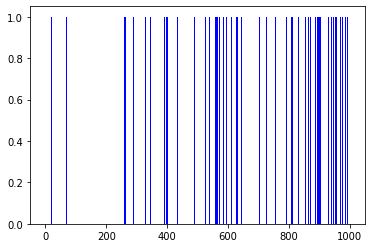

episode:    0 | success rate : 0.00
episode:   10 | success rate : 0.03
episode:   20 | success rate : 0.09
episode:   30 | success rate : 0.16
episode:   40 | success rate : 0.21
episode:   50 | success rate : 0.29
episode:   60 | success rate : 0.35
episode:   70 | success rate : 0.40
episode:   80 | success rate : 0.45
episode:   90 | success rate : 0.50
success rate: 0.58 | average steps: 35.3900


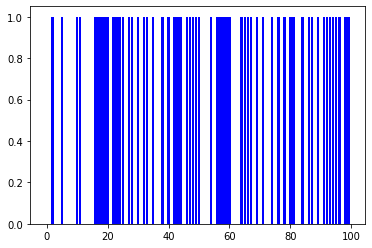

In [18]:
print("score_avg: {:6.2f}".format(sum(scores) / len(scores)))
act_string = ["LEFT", "DOWN", "RIGHT", "UP"]
for state_ in range(env.observation_space.n):
    state = reshape_state(state_, env.observation_space.n)
    action = np.argmax(agent.model.predict(state))
    if state_ % 4 == 3:
        print(act_string[action])
    else:
        print(act_string[action], end=" ")

import matplotlib.pyplot as plt
plt.bar(range(len(scores)), scores, color='blue')
plt.show()

def test():
    state_size = env.observation_space.n
    episodes = 100
    rewards = []
    lengths = []
    for episode in range(episodes):
        score = 0
        length = 0
        state = reshape_state(env.reset(), state_size)
        done = False
        while not done:
            action = np.argmax(agent.model.predict(state))
            next_state, reward, done, info = env.step(action)
            length += 1
            score += reward
            state = reshape_state(next_state, state_size)
        rewards.append(score)
        lengths.append(length)
        if episode % (episodes / 10) == 0:
            print("episode: {:4d} | success rate : {:.2f}".format(episode, sum(rewards) / episodes))
    print("success rate: {:.2f} | average steps: {:.4f}".format(sum(rewards) / episodes, sum(lengths) / episodes))
    plt.bar(range(episodes), rewards, color = 'blue')
    plt.show()

test()

#MountainCar

In [6]:
import numpy as np
import tensorflow as tf
import random
from collections import deque

class DQN(tf.keras.Model):
    def __init__(self, action_size):
        self.layer1 = tf.keras.layers.Dense(24, activation='relu')
        self.layer2 = tf.keras.layers.Dense(24, activation='relu')
        self.layer_out = tf.keras.layers.Dense(action_size, activation='linear')
    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        q = self.layer_out(x)
        return q

class DQNAgent():
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = 0.01
        self.epsilon = 1.
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01
        self.batch_size = 32
        self.train_start = 1000
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.memory = deque(maxlen=10000)

        self.update_target_model()
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    def choose_action(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def train(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        batch = random.sample(self.memory, self.batch_size)
        states = np.array([sample[0] for sample in batch])
        actions = np.array
    